## Test the image retreival
During testing, querying many of the local hashtables gave 0 distance, so I want to see the types of images that are getting matched.

In [1]:
import os
import torch
import loader
import pickle
import PIL

import matplotlib.pyplot as plt
import torch.nn as nn
from lshash.lshash import LSHash
from torch.utils.data import DataLoader
from model.resnet50 import ResNet50
from tqdm import tqdm

IMG_DIR = '../images'
INDEX_IMG = 'eval/index'
CSV_DIR = '../images/meta'
LSH_PATH = './.lshnp'
CSV_PATH = 'query_part2.csv'
CHKPT = './.checkpoints/model.pt'

out_file = 'out.csv'
batch_size = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')


In [2]:
dataset = loader.eProductTestDataset(
                '../images/meta', 'query_part2.csv'
            )
dataloader = DataLoader(dataset, batch_size=batch_size)

checkpoint = torch.load(CHKPT)
model = ResNet50(num_classes=[16, 77, 1000]).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()


ResNet50(
  (conv_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (identity_connection): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, e

In [3]:
def show_image(path):
    plt.imshow(PIL.Image.open(path))
    plt.show()

def write_to_file(img_uuid, sim_imgs, fp):
    fp.write(f"{img_uuid},{' '.join(sim_imgs)}")
# Scan through all pickled files?
def get_closest_images(emb, sim_thresh=0.9):
    sim_imgs = [] # UUID of similar images
    
    for file in os.listdir(LSH_PATH):
        f = open(os.path.join(LSH_PATH, file), 'rb')
        lsh = pickle.load(f)
        res =lsh.query(emb, num_results=1, distance_func='cosine')
        for item in res:
            #print(item)
            if item[1] == 0.0:
                imgname = item[0][1]
                sim_imgs.append(imgname)
                show_image(os.path.join(f'../images/eval/index/{imgname}.JPEG'))                
        print('\n')
    return sim_imgs


0it [00:00, ?it/s]

orig image:


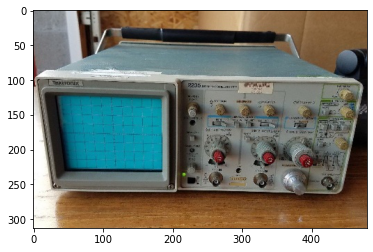

0it [00:00, ?it/s]

The input point needs to be of the same dimension as
                  `input_dim` when initializing this LSHash instance shapes (20,1002) and (3,) not aligned: 1002 (dim 1) != 3 (dim 0)


ValueError: shapes (20,1002) and (3,) not aligned: 1002 (dim 1) != 3 (dim 0)

In [4]:
# Get embeddings
with torch.no_grad():
    with open(out_file, 'w') as f:
        for i, (uuid, img) in tqdm(enumerate(dataloader)):
            #if i < 4:
            #    continue
            print('orig image:')
            show_image(os.path.join(f'../images/query_part2/{uuid[0]}.JPEG'))                
            img = img.to(device)
            preds = model(img)
            preds_concat = torch.concat([torch.argmax(preds[0], dim=1).reshape((1, 1)),
                                        torch.argmax(preds[1], dim=1).reshape((1,1)),
                                        torch.argmax(preds[2], dim=1).reshape((1,1))], dim=1)

            preds_concat = preds_concat.cpu()
            sims = get_closest_images(preds_concat.reshape(3,))
            write_to_file(uuid[0], sims, f)

            break
